In [75]:
import pandas as pd
import numpy as np
audata = pd.read_csv("RESULT_new3/fu/fu2109_fu2201_final.csv", index_col=[0], parse_dates=[0])
audata.index = audata.index + pd.Timedelta(hours=5)
audata

FileNotFoundError: [Errno 2] No such file or directory: 'RESULT_new3/cu/cu2106_cu2107_final.csv'

In [ ]:
data_all = audata

pd_date_list = pd.DataFrame()
pd_date_list['time_stamp'] = pd.to_datetime(data_all['trading_date'])
# normalize, count values, convert to dataframe
pd_date_list = pd_date_list['time_stamp'].dt.normalize().value_counts().to_frame().reset_index()
# rename columns
pd_date_list.columns = ['time_stamp', 'count']
pd_date_list.sort_values(by='time_stamp',inplace=True)
pd_date_list = pd_date_list.reset_index()
pd_date_list.drop(columns='index',inplace=True)
pd_date_list


In [ ]:
def find_best_k(MSpread,Spread):
    cost_rate = 0.5 / 10000
    best_K = None
    best_K_res = None


    K_options = np.arange(0.01, 2, 0.01)
    k_res = 1
    for K in K_options:
        
        holding = False
        direction = None  # "a-b", "b-a"
        enter_record = []
        out_record = []

        pure_pnl = []
        trading_cost = []
        pnl = []
        
        up_threshold =  K * np.std(MSpread)
        down_threshold = - up_threshold
        
        for i, v in enumerate(MSpread):
            if not holding:
                # 判断进场条件
                if v > up_threshold:
                    holding = True
                    direction = 'b-a'
                    enter_record.append((i, v))
                elif v < down_threshold:
                    holding = True
                    direction = 'a-b'
                    enter_record.append((i, v))

            elif holding:
                # 判断离场条件
                if direction == 'a-b' and v > 0.1:
                    holding = False
                    out_record.append((i, v))

                    out_price = Spread[i]
                    last_enter_price = Spread[enter_record[-1][0]]
                    single_ret = (out_price - last_enter_price)
                    single_cost = cost_rate * (data.last_A[i] + data.last_B[i] + 
                                                data.last_A[enter_record[-1][0]] + data.last_B[enter_record[-1][0]])

                    pure_pnl.append(single_ret)
                    trading_cost.append(single_cost)
                    pnl.append(single_ret - single_cost)


                elif direction =='b-a' and v < -0.1:
                    holding = False
                    out_record.append((i, v))
                    out_price = Spread[i]
                    last_enter_price = Spread[enter_record[-1][0]]
                    single_ret = (last_enter_price - out_price)
                    single_cost = cost_rate * (data.last_A[i] + data.last_B[i] + 
                                                data.last_A[enter_record[-1][0]] + data.last_B[enter_record[-1][0]])            

                    pure_pnl.append(single_ret)
                    trading_cost.append(single_cost)
                    pnl.append(single_ret - single_cost)

                    
        if holding:
            # print('还有持仓，强平')
            if direction == 'a-b':
                ret = (Spread[-1] - Spread[enter_record[-1][0]])
            else:
                ret = (Spread[enter_record[-1][0]] - Spread[-1])

            single_cost = cost_rate * (data.last_A[-1] + data.last_B[-1] + 
                                                    data.last_A[enter_record[-1][0]] + data.last_B[enter_record[-1][0]])
            pure_pnl.append(ret)
            trading_cost.append(single_cost)
            pnl.append(ret - single_cost)
        if len(pnl) > 0:
            final_pnl = np.array(pnl).cumsum()[-1]
            if best_K_res is None:
                best_K_res = final_pnl
                K_res = K
                
            elif final_pnl > best_K_res:
                best_K_res = final_pnl
                k_res = K
    print(k_res,best_K_res)
    return k_res

In [73]:
import statsmodels.api as sm
import datetime
K_options = np.arange(0.1, 10, 0.1)
res_test = []
for K in K_options:

    holding = False
    direction = None  # "a-b", "b-a"
    stop_event = "none"
    enter_record = []
    out_record = []

    pure_pnl = []
    trading_cost = []
    pnl = []
    cost_rate = 0.5 / 10000
    delta_days = 1
    beta = 0
    data_all['trading_date']  =  pd.to_datetime(data_all['trading_date']) #处理交易日时刻
    #取最近5天数据
    for date_index in range(0,len(pd_date_list) - delta_days):

        start_time = pd_date_list['time_stamp'].iloc[date_index]
        end_time = pd_date_list['time_stamp'].iloc[date_index + delta_days]
        data = data_all[(data_all['trading_date'] >= start_time) & (data_all['trading_date'] < end_time)]

        start_time = pd_date_list['time_stamp'].iloc[date_index + delta_days]
        end_time = pd_date_list['time_stamp'].iloc[date_index + delta_days]  + pd.Timedelta("1 day")
        test_data = data_all[(data_all['trading_date'] >= start_time) & (data_all['trading_date'] < end_time)]

        model = sm.OLS(data.last_A, data.last_B).fit()
        

        beta = model.params['last_B']


        eps = data.last_A - data.last_B * beta
        eps2 = test_data.last_A - test_data.last_B * beta
        eps2_ask = test_data.bid_A - test_data.ask_B * beta
        eps2_bid = test_data.ask_A - test_data.bid_B * beta

        Spread = data.last_A - data.last_B
        Spread2 = test_data.last_A - test_data.last_B
        Spread2_ask = test_data.bid_A - test_data.ask_B
        Spread2_bid = test_data.ask_A - test_data.bid_B

        print(" ")
        print('test_day:',start_time)
        print(model.params)
        # best_k = find_best_k(eps,Spread)

        #进入交易
        # if K == 0:
        #     K = best_k

        # K = best_k * 0.4 + K * 0.6
        up_threshold =  K #* np.std(eps)
        down_threshold = - up_threshold

        # temp = np.std(eps) * 5
        # up_threshold_stop = temp * 0.4 + up_threshold_stop *0.6
        up_threshold_stop = np.std(eps) * 6
        biggest_lost = -20
        # if up_threshold_stop < 60:
        #     up_threshold_stop = 60
        # if up_threshold_stop > 200:
        #     up_threshold_stop = 200
        # down_threshold_stop = -up_threshold_stop


        print('beta:',beta)
        print('阈值：',up_threshold)
        print('止损点：',up_threshold_stop)

        for i, v in enumerate(eps2.values):
            #交易时间点判断:去除开盘前10分钟和收盘前十分钟
            start_time1 = datetime.time(2,10,0)
            start_time2 = datetime.time(14,10,0)

            end_time1 = datetime.time(5,50,0)
            end_time2 = datetime.time(19,50,0)
            
            if (eps2_ask.index[i].time() > start_time1 and eps2_ask.index[i].time() < end_time1) or \
                (eps2_ask.index[i].time() > start_time2 and eps2_ask.index[i].time() < end_time2):

                ask_price = eps2_ask[i]
                bid_price = eps2_bid[i]
                if not holding:
                    # 判断进场条件
                    if ask_price > up_threshold and stop_event != 'up_stop':
                        holding = True
                        stop_event = "none"
                        direction = 'b-a'
                        print(len(enter_record),Spread2_ask.index[i],'b-a进场', Spread2_ask[i], ask_price)
                        enter_record.append((Spread2_ask[i], ask_price))
                    elif bid_price < down_threshold and stop_event != 'down_stop':
                        holding = True
                        stop_event = "none"
                        direction = 'a-b'
                        print(len(enter_record),Spread2_bid.index[i],'a-b进场', Spread2_bid[i], bid_price)
                        enter_record.append((Spread2_bid[i], bid_price))
                        
                elif holding:
                    # 判断离场条件
                    if direction == 'a-b' and ask_price > 0.001:
                        holding = False
                        print(Spread2_ask.index[i],'a-b出场', Spread2_ask[i], ask_price)
                        out_record.append((Spread2_ask[i], ask_price))
                        
                        out_price = Spread2_ask[i]
                        last_enter_price = enter_record[-1][0]
                        single_ret = (out_price - last_enter_price)
                        single_cost = cost_rate * (test_data.last_A[i] + test_data.last_B[i]) * 2

                        pure_pnl.append(single_ret)
                        trading_cost.append(single_cost)
                        pnl.append(single_ret - single_cost)
                        
                        
                    elif direction =='b-a' and bid_price < -0.001:
                        holding = False
                        print(Spread2_bid.index[i],'b-a出场', Spread2_bid[i], bid_price)
                        out_record.append((Spread2_bid[i], bid_price))
                        out_price = Spread2_bid[i]
                        last_enter_price = enter_record[-1][0]
                        single_ret = (last_enter_price - out_price)
                        single_cost = cost_rate * (test_data.last_A[i] + test_data.last_B[i]) * 2           
                        
                        pure_pnl.append(single_ret)
                        trading_cost.append(single_cost)
                        pnl.append(single_ret - single_cost)

                    # 判断止损条件
                    elif direction == 'a-b' and ask_price < down_threshold_stop:
                        holding = False
                        stop_event = 'down_stop'
                        print(Spread2_ask.index[i],'a-b止损出场', Spread2_ask[i], ask_price)
                        out_record.append((Spread2_ask[i], ask_price))
                        
                        out_price = Spread2_ask[i]
                        last_enter_price = enter_record[-1][0]
                        single_ret = (out_price - last_enter_price)
                        single_cost = cost_rate * (test_data.last_A[i] + test_data.last_B[i]) * 2

                        pure_pnl.append(single_ret)
                        trading_cost.append(single_cost)
                        pnl.append(single_ret - single_cost)
                        
                        
                    elif direction =='b-a' and bid_price > up_threshold_stop:
                        holding = False
                        stop_event = 'up_stop'
                        print(Spread2_bid.index[i],'b-a止损出场', Spread2_bid[i], bid_price)
                        out_record.append((Spread2_bid[i], bid_price))
                        out_price = Spread2_bid[i]
                        last_enter_price = enter_record[-1][0]
                        single_ret = (last_enter_price - out_price)
                        single_cost = cost_rate * (test_data.last_A[i] + test_data.last_B[i]) * 2           
                        
                        pure_pnl.append(single_ret)
                        trading_cost.append(single_cost)
                        pnl.append(single_ret - single_cost)
                    else: #判断最大亏损有没有达到阈值
                        if direction == 'a-b':
                            out_price = Spread2_ask[i]
                            last_enter_price = enter_record[-1][0]
                            single_ret = (out_price - last_enter_price)
                            if single_ret < biggest_lost:
                                holding = False
                                stop_event = 'down_stop'
                                print(Spread2_ask.index[i],'a-b收益止损出场', Spread2_ask[i], ask_price)
                                out_record.append((Spread2_ask[i], ask_price))
                                single_cost = cost_rate * (test_data.last_A[i] + test_data.last_B[i]) * 2
                                pure_pnl.append(single_ret)
                                trading_cost.append(single_cost)
                                pnl.append(single_ret - single_cost)
                        elif direction =='b-a':
                            out_price = Spread2_bid[i]
                            last_enter_price = enter_record[-1][0]
                            single_ret = (last_enter_price - out_price)
                            if single_ret < biggest_lost:
                                holding = False
                                stop_event = 'up_stop'
                                print(Spread2_bid.index[i],'b-a收益止损出场', Spread2_bid[i], bid_price)
                                out_record.append((Spread2_bid[i], bid_price))
                                single_cost = cost_rate * (test_data.last_A[i] + test_data.last_B[i]) * 2           
                                
                                pure_pnl.append(single_ret)
                                trading_cost.append(single_cost)
                                pnl.append(single_ret - single_cost)

                
    if holding:
        print('还有持仓，强平',Spread2_bid[i], bid_price)
        if direction == 'a-b':
            ret = (Spread2_ask[-1] - enter_record[-1][0])
        else:
            ret = (enter_record[-1][0] - Spread2_bid[-1])
        
        single_cost = cost_rate * (test_data.last_A[i] + test_data.last_B[i]) * 2  
        pure_pnl.append(ret)
        trading_cost.append(single_cost)
        pnl.append(ret - single_cost)

    res_test.append([K,np.array(pnl).sum()])


59649268
 
test_day: 2021-05-10 00:00:00
last_B    1.014551
dtype: float64
beta: 1.0145510194588898
阈值： 9.5
止损点： 11.275045648265476
7 2021-05-10 16:00:01.500000 a-b进场 27.0 -9.755875153155557
2021-05-10 16:29:56 a-b止损出场 21.0 -15.406650686142257
 
test_day: 2021-05-11 00:00:00
last_B    1.011872
dtype: float64
beta: 1.0118720131367192
阈值： 9.5
止损点： 24.414354283365043
 
test_day: 2021-05-12 00:00:00
last_B    1.004789
dtype: float64
beta: 1.0047889169554076
阈值： 9.5
止损点： 26.88351690602694
 
test_day: 2021-05-13 00:00:00
last_B    1.006895
dtype: float64
beta: 1.006895439762549
阈值： 9.5
止损点： 10.695562215953181
 
test_day: 2021-05-14 00:00:00
last_B    1.005254
dtype: float64
beta: 1.00525353660749
阈值： 9.5
止损点： 22.336035957605958
 
test_day: 2021-05-17 00:00:00
last_B    1.000844
dtype: float64
beta: 1.000844069365086
阈值： 9.5
止损点： 25.058496554362407
 
test_day: 2021-05-18 00:00:00
last_B    1.000178
dtype: float64
beta: 1.0001775529276198
阈值： 9.5
止损点： 13.757497742924969
 
test_day: 2021-05-19 

In [74]:
res_test

[[0.1, -79.52459999999999],
 [0.2, -72.0788],
 [0.30000000000000004, -43.0418],
 [0.4, -38.0418],
 [0.5, -36.071200000000005],
 [0.6, -32.06880000000001],
 [0.7000000000000001, -26.576599999999996],
 [0.8, -24.56860000000001],
 [0.9, -24.104600000000012],
 [1.0, -16.610300000000013],
 [1.1, -14.109200000000005],
 [1.2000000000000002, -12.141400000000003],
 [1.3000000000000003, -14.194900000000006],
 [1.4000000000000001, -12.717900000000007],
 [1.5000000000000002, -12.2537],
 [1.6, -9.294600000000004],
 [1.7000000000000002, -13.299300000000013],
 [1.8000000000000003, -6.94690000000001],
 [1.9000000000000001, -4.9469000000000065],
 [2.0, 0.5465999999999962],
 [2.1, 4.546599999999996],
 [2.2, 8.546599999999996],
 [2.3000000000000003, 11.036499999999995],
 [2.4000000000000004, 9.552899999999996],
 [2.5000000000000004, 9.552899999999996],
 [2.6, 9.032199999999994],
 [2.7, 9.032199999999994],
 [2.8000000000000003, 10.520599999999991],
 [2.9000000000000004, 13.520599999999991],
 [3.0000000000

In [68]:
import statsmodels.api as sm
import datetime
holding = False
direction = None  # "a-b", "b-a"
stop_event = "none"
enter_record = []
out_record = []

pure_pnl = []
trading_cost = []
pnl = []
cost_rate = 0.5 / 10000
delta_days = 1
K = 0
beta = 0
data_all['trading_date']  =  pd.to_datetime(data_all['trading_date']) #处理交易日时刻
#取最近5天数据
for date_index in range(0,len(pd_date_list) - delta_days):

    start_time = pd_date_list['time_stamp'].iloc[date_index]
    end_time = pd_date_list['time_stamp'].iloc[date_index + delta_days]
    data = data_all[(data_all['trading_date'] >= start_time) & (data_all['trading_date'] < end_time)]

    start_time = pd_date_list['time_stamp'].iloc[date_index + delta_days]
    end_time = pd_date_list['time_stamp'].iloc[date_index + delta_days]  + pd.Timedelta("1 day")
    test_data = data_all[(data_all['trading_date'] >= start_time) & (data_all['trading_date'] < end_time)]

    model = sm.OLS(data.last_A, data.last_B).fit()
    

    beta = model.params['last_B']


    eps = data.last_A - data.last_B * beta
    eps2 = test_data.last_A - test_data.last_B * beta
    eps2_ask = test_data.bid_A - test_data.ask_B * beta
    eps2_bid = test_data.ask_A - test_data.bid_B * beta

    Spread = data.last_A - data.last_B
    Spread2 = test_data.last_A - test_data.last_B
    Spread2_ask = test_data.bid_A - test_data.ask_B
    Spread2_bid = test_data.ask_A - test_data.bid_B

    print(" ")
    print('test_day:',start_time)
    print(model.params)
    # best_k = find_best_k(eps,Spread)

    #进入交易
    # if K == 0:
    #     K = best_k

    # K = best_k * 0.4 + K * 0.6
    # K = 0.5
    # up_threshold =  K * np.std(eps)
    up_threshold = 5
    down_threshold = - up_threshold

    # temp = np.std(eps) * 5
    # up_threshold_stop = temp * 0.4 + up_threshold_stop *0.6
    up_threshold_stop = np.std(eps) * 6
    biggest_lost = -20
    # if up_threshold_stop < 60:
    #     up_threshold_stop = 60
    # if up_threshold_stop > 200:
    #     up_threshold_stop = 200
    down_threshold_stop = -up_threshold_stop


    print('beta:',beta)
    print('阈值：',up_threshold)
    print('止损点：',up_threshold_stop)

    for i, v in enumerate(eps2.values):
        #交易时间点判断:去除开盘前10分钟和收盘前十分钟
        start_time1 = datetime.time(2,10,0)
        start_time2 = datetime.time(14,10,0)

        end_time1 = datetime.time(5,50,0)
        end_time2 = datetime.time(19,50,0)
        
        if (eps2_ask.index[i].time() > start_time1 and eps2_ask.index[i].time() < end_time1) or \
            (eps2_ask.index[i].time() > start_time2 and eps2_ask.index[i].time() < end_time2):

            ask_price = eps2_ask[i]
            bid_price = eps2_bid[i]
            if not holding:
                # 判断进场条件
                if ask_price > up_threshold and stop_event != 'up_stop':
                    holding = True
                    stop_event = "none"
                    direction = 'b-a'
                    print(len(enter_record),Spread2_ask.index[i],'b-a进场', Spread2_ask[i], ask_price)
                    enter_record.append((Spread2_ask[i], ask_price))
                elif bid_price < down_threshold and stop_event != 'down_stop':
                    holding = True
                    stop_event = "none"
                    direction = 'a-b'
                    print(len(enter_record),Spread2_bid.index[i],'a-b进场', Spread2_bid[i], bid_price)
                    enter_record.append((Spread2_bid[i], bid_price))
                    
            elif holding:
                # 判断离场条件
                if direction == 'a-b' and ask_price > 0.001:
                    holding = False
                    print(Spread2_ask.index[i],'a-b出场', Spread2_ask[i], ask_price)
                    out_record.append((Spread2_ask[i], ask_price))
                    
                    out_price = Spread2_ask[i]
                    last_enter_price = enter_record[-1][0]
                    single_ret = (out_price - last_enter_price)
                    single_cost = cost_rate * (test_data.last_A[i] + test_data.last_B[i]) * 2

                    pure_pnl.append(single_ret)
                    trading_cost.append(single_cost)
                    pnl.append(single_ret - single_cost)
                    
                    
                elif direction =='b-a' and bid_price < -0.001:
                    holding = False
                    print(Spread2_bid.index[i],'b-a出场', Spread2_bid[i], bid_price)
                    out_record.append((Spread2_bid[i], bid_price))
                    out_price = Spread2_bid[i]
                    last_enter_price = enter_record[-1][0]
                    single_ret = (last_enter_price - out_price)
                    single_cost = cost_rate * (test_data.last_A[i] + test_data.last_B[i]) * 2           
                    
                    pure_pnl.append(single_ret)
                    trading_cost.append(single_cost)
                    pnl.append(single_ret - single_cost)

                #判断止损条件
                elif direction == 'a-b' and ask_price < down_threshold_stop:
                    holding = False
                    stop_event = 'down_stop'
                    print(Spread2_ask.index[i],'a-b止损出场', Spread2_ask[i], ask_price)
                    out_record.append((Spread2_ask[i], ask_price))
                    
                    out_price = Spread2_ask[i]
                    last_enter_price = enter_record[-1][0]
                    single_ret = (out_price - last_enter_price)
                    single_cost = cost_rate * (test_data.last_A[i] + test_data.last_B[i]) * 2

                    pure_pnl.append(single_ret)
                    trading_cost.append(single_cost)
                    pnl.append(single_ret - single_cost)
                    
                    
                elif direction =='b-a' and bid_price > up_threshold_stop:
                    holding = False
                    stop_event = 'up_stop'
                    print(Spread2_bid.index[i],'b-a止损出场', Spread2_bid[i], bid_price)
                    out_record.append((Spread2_bid[i], bid_price))
                    out_price = Spread2_bid[i]
                    last_enter_price = enter_record[-1][0]
                    single_ret = (last_enter_price - out_price)
                    single_cost = cost_rate * (test_data.last_A[i] + test_data.last_B[i]) * 2           
                    
                    pure_pnl.append(single_ret)
                    trading_cost.append(single_cost)
                    pnl.append(single_ret - single_cost)
                else: #判断最大亏损有没有达到阈值
                    if direction == 'a-b':
                        out_price = Spread2_ask[i]
                        last_enter_price = enter_record[-1][0]
                        single_ret = (out_price - last_enter_price)
                        if single_ret < biggest_lost:
                            holding = False
                            stop_event = 'down_stop'
                            print(Spread2_ask.index[i],'a-b收益止损出场', Spread2_ask[i], ask_price)
                            out_record.append((Spread2_ask[i], ask_price))
                            single_cost = cost_rate * (test_data.last_A[i] + test_data.last_B[i]) * 2
                            pure_pnl.append(single_ret)
                            trading_cost.append(single_cost)
                            pnl.append(single_ret - single_cost)
                    elif direction =='b-a':
                        out_price = Spread2_bid[i]
                        last_enter_price = enter_record[-1][0]
                        single_ret = (last_enter_price - out_price)
                        if single_ret < biggest_lost:
                            holding = False
                            stop_event = 'up_stop'
                            print(Spread2_bid.index[i],'b-a收益止损出场', Spread2_bid[i], bid_price)
                            out_record.append((Spread2_bid[i], bid_price))
                            single_cost = cost_rate * (test_data.last_A[i] + test_data.last_B[i]) * 2           
                            
                            pure_pnl.append(single_ret)
                            trading_cost.append(single_cost)
                            pnl.append(single_ret - single_cost)

            
if holding:
    print('还有持仓，强平',Spread2_bid[i], bid_price)
    if direction == 'a-b':
        ret = (Spread2_ask[-1] - enter_record[-1][0])
    else:
        ret = (enter_record[-1][0] - Spread2_bid[-1])
    
    single_cost = cost_rate * (test_data.last_A[i] + test_data.last_B[i]) * 2  
    pure_pnl.append(ret)
    trading_cost.append(single_cost)
    pnl.append(ret - single_cost)


 
test_day: 2021-04-02 00:00:00
last_B    1.00737
dtype: float64
beta: 1.0073698191158713
阈值： 5
止损点： 34.66130373662871
0 2021-04-02 03:36:40 a-b进场 12.0 -5.503320400194298
2021-04-02 14:53:51.500000 a-b出场 18.0 0.24610574986581923
1 2021-04-02 19:07:05 b-a进场 23.0 5.142928282243702
 
test_day: 2021-04-06 00:00:00
last_B    1.007267
dtype: float64
beta: 1.007266718625118
阈值： 5
止损点： 28.796990433144277
2021-04-06 14:10:00.500000 b-a出场 3.0 -14.142189236653394
2 2021-04-06 14:10:06 a-b进场 3.0 -14.142189236653394
 
test_day: 2021-04-07 00:00:00
last_B    1.00349
dtype: float64
beta: 1.0034895230274858
阈值： 5
止损点： 20.801472003416457
2021-04-07 02:10:01 a-b出场 11.0 2.7961313623809474
3 2021-04-07 02:16:08.500000 b-a进场 14.0 5.813578977518318
2021-04-07 14:10:04.500000 b-a出场 8.0 -0.17944197642691506
4 2021-04-07 15:31:15.500000 a-b进场 3.0 -5.120120084959581
2021-04-07 16:24:46 a-b出场 9.0 0.8624322999030483
 
test_day: 2021-04-08 00:00:00
last_B    1.004119
dtype: float64
beta: 1.0041188169126
阈值： 5
止损点：

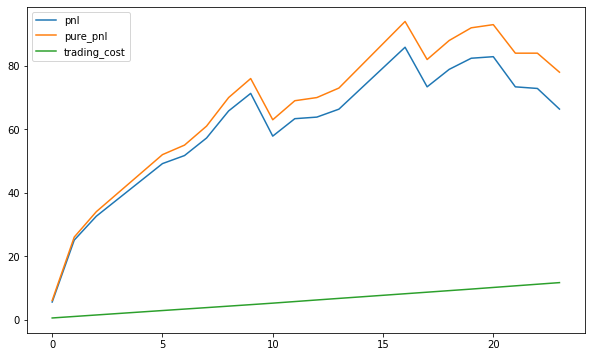

66.36609999999999

In [69]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.plot(np.array(pnl).cumsum(), label='pnl')
plt.plot(np.array(pure_pnl).cumsum(), label='pure_pnl')
plt.plot(np.array(trading_cost).cumsum(), label='trading_cost')
plt.legend()
plt.show()
np.array(pnl).sum()

In [ ]:
start_time = pd_date_list['time_stamp'].iloc[34]
end_time = pd_date_list['time_stamp'].iloc[34] + pd.Timedelta("1 day")
data = data_all[(data_all.index >= start_time) & (data_all.index <= end_time)]

model = sm.OLS(data.last_A, data.last_B).fit()
print(data)
print(model.params)

beta = model.params['last_B']

eps = data.last_A - data.last_B * beta

Spread = data.last_A - data.last_B
best_k = find_best_k(eps,Spread)

#进入交易

K_use = best_k * 0.4 + K * 0.6
up_threshold =  K_use * np.std(eps)
down_threshold = - up_threshold
print(K_use)

In [ ]:
up_threshold